In [1]:
import scipy
import scipy.io
import numpy as np
from scipy.linalg import norm
from scipy.sparse import csr_matrix
from scipy.linalg import norm
import pickle
import time
from collections import defaultdict
import json
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import pandas as pd
import numpy.matlib
import import_ipynb
import Portfolio as pr
import FW
import SCOPT as sc
#import SCOPT


importing Jupyter notebook from Portfolio.ipynb
importing Jupyter notebook from FW.ipynb
importing Jupyter notebook from SCOPT.ipynb


In [2]:
results = defaultdict(dict)
with open('./results/results_portfolio_dict.pckl', 'rb') as f:
        results=pickle.load(f)

## Data load

In [3]:
example='syn_1000_1500_10_50'
data = scipy.io.loadmat('./data/'+example+'.mat')
R = data['W']

### Some preprocessing

In [4]:
N, n = R.shape
Mf = 2
nu = 3
I = np.eye(n)
Iv = np.ones(n)

#running parameters
x0 = np.ones(n) / n
terminate_tol = 1e-10

#parameters for FW
FW_params={
    'iter_FW':50000,
    'line_search_tol':1e-10,
}


sc_params={
    #parameters for SCOPT
    'iter_SC': 1000,
    'Lest': 'backtracking',#,'estimate', #estimate L
    'use_two_phase':False,
    #FISTA parameters
    'fista_type': 'mfista',
    'fista_tol': 1e-5,
    'fista_iter': 1000,
    #Conjugate Gradient Parameters
    'conj_grad_tol':1e-5,
    'conj_grad_iter':1000,
}

## Auxilary functions

In [5]:
func_x = lambda x: pr.portfolio(R,x)
grad_x = lambda x,dot_product: pr.grad_portfolio(R, x,dot_product)
grad_beta = lambda x,s,beta,dot_product,dot_product_s: pr.grad_portfolio(R, (1-beta)*x+beta*x,(1-beta)*dot_product+beta*dot_product_s)
hess_mult_x = lambda x,dot_product: pr.hess_mult_portfolio(R, x, dot_product)
hess_mult_vec_x= lambda s,dot_product: pr.hess_mult_vec(R, s, dot_product)
extra_func = lambda x: R@x
linear_orcale = lambda grad: pr.linear_oracle_simplex(grad)
prox_func=lambda x,L: pr.proj_simplex(x)

# Run FW

In [6]:
run_alpha_policies = ["standard","line_search","icml"]


for policy in run_alpha_policies:
    x, alpha_hist, Gap_hist, Q_hist, time_hist, grad_hist = FW.frank_wolfe(func_x,
                       grad_x,
                       grad_beta,
                       hess_mult_x,
                       extra_func,                                                    
                       Mf,
                       nu,
                       linear_orcale,                                                    
                       x0,
                       FW_params,        
                       alpha_policy=policy,                                                    
                       eps=terminate_tol, 
                       print_every=1000, 
                       debug_info=False)
    
    results[example][policy] = {
        'x': x,
        'alpha_hist': alpha_hist,
        'Gap_hist': Gap_hist,
        'Q_hist': Q_hist,
        'time_hist': time_hist,
        'grad_hist': grad_hist
    }
    

********* Algorithm starts *********
iter = 1, stepsize = 0.6666666666666666, criterion = 0.6664444073950565, upper_bound=0.02128931286912572, lower_bound=-4.917163298675437
iter = 1000, stepsize = 0.001996007984031936, criterion = 0.0015571040685596691, upper_bound=-4.475083631695005, lower_bound=-4.4755809174262335
iter = 2000, stepsize = 0.000999000999000999, criterion = 0.0007783134107878446, upper_bound=-4.475090642267521, lower_bound=-4.475279506200641
iter = 3000, stepsize = 0.0006662225183211193, criterion = 0.0005181100345580247, upper_bound=-4.475091916629843, lower_bound=-4.4752461902281
iter = 4000, stepsize = 0.0004997501249375312, criterion = 0.0003887085045493703, upper_bound=-4.475092359793131, lower_bound=-4.475200870360067
iter = 5000, stepsize = 0.00039984006397441024, criterion = 0.0003110223336802688, upper_bound=-4.475092560511081, lower_bound=-4.47517822487111
iter = 6000, stepsize = 0.0003332222592469177, criterion = 0.00025922079967137117, upper_bound=-4.475092

iter = 3000, stepsize = 0.00024861107241036225, criterion = 0.00022064363947173484, upper_bound=-4.474783570515688, lower_bound=-4.475276368789769
iter = 4000, stepsize = 0.00019894689954688197, criterion = 0.00016602803498786452, upper_bound=-4.4748612319563055, lower_bound=-4.475230972490262
iter = 5000, stepsize = 0.00013471025382479543, criterion = 0.00013049324217062904, upper_bound=-4.4749077199794804, lower_bound=-4.475201432763949
iter = 6000, stepsize = 0.00021673697982404816, criterion = 0.00010923729002243724, upper_bound=-4.474938666248177, lower_bound=-4.475183761643811
iter = 7000, stepsize = 0.0001528218954616492, criterion = 9.393551009005379e-05, upper_bound=-4.474960768547722, lower_bound=-4.475171039937942
iter = 8000, stepsize = 8.856429469877977e-05, criterion = 8.239357177895274e-05, upper_bound=-4.474977329682568, lower_bound=-4.475161443793816
iter = 9000, stepsize = 0.00011891032477559272, criterion = 7.258312428277157e-05, upper_bound=-4.474990195105603, lower

## Run SCOPT

In [7]:
 x, alpha_hist, Q_hist, time_hist, grad_hist = sc.scopt(func_x,
          grad_x,
          hess_mult_x,
          hess_mult_vec_x,
          Mf,
          nu,
          prox_func,
          x0,  
          sc_params,                                              
          eps=terminate_tol,                                              
          print_every=10)
    
results[example]['scopt'] = {
    'x': x,
    'alpha_hist': alpha_hist,
    'Gap_hist': Gap_hist,
    'Q_hist': Q_hist,
    'time_hist': time_hist,
    'grad_hist': grad_hist
}

iter =    1, stepsize = 5.668e-01, rdiff = 4.786e-01 , f = 0.0212893

Fista err = 9.957e-06; Subiter = 149; subproblem converged!

Fista err = 8.186e-06; Subiter =   7; subproblem converged!

Fista err = 8.063e-06; Subiter =   2; subproblem converged!

Fista err = 3.464e-06; Subiter =   2; subproblem converged!

Fista err = 1.635e-07; Subiter =   2; subproblem converged!

Convergence achieved!
iter =    7, stepsize = 0.000e+00, rdiff = 0.000e+00,value=-4.47509

13.15505051612854


## Save results

In [8]:
with open('./results/results_portfolio_dict.pckl', 'wb') as f:
    pickle.dump(results, f)

## Summarize

In [11]:
methods= ["standard","line_search","icml","scopt"]
for example in ['syn_1000_800_10_50','syn_1000_1200_10_50','syn_1000_1500_10_50']:
    for method in methods:
    
        x=results[example][method]['x']
        time_hist=results[example][method]['time_hist']
        Q_hist=results[example][method]['Q_hist']
    
        print(example,method)
        print("sum_x=%g,iteration=%d,total_time=%3.3e,time_per_iter=%g,minimal_val=%1.7f\n"%(sum(abs(x)),len(time_hist)-1,sum(time_hist),sum(time_hist)/(len(time_hist)-1),
            min(Q_hist)))


syn_1000_800_10_50 standard
sum_x=1,iteration=50000,total_time=1.290e+02,time_per_iter=0.00257909,minimal_val=-4.5714135

syn_1000_800_10_50 line_search
sum_x=1,iteration=129,total_time=6.536e-01,time_per_iter=0.00506666,minimal_val=-4.5714136

syn_1000_800_10_50 icml
sum_x=1,iteration=50000,total_time=1.519e+02,time_per_iter=0.00303877,minimal_val=-4.5713964

syn_1000_800_10_50 scopt
sum_x=1,iteration=7,total_time=4.118e+00,time_per_iter=0.588285,minimal_val=-4.5714138

syn_1000_1200_10_50 standard
sum_x=1,iteration=50000,total_time=1.993e+02,time_per_iter=0.00398672,minimal_val=-5.1190193

syn_1000_1200_10_50 line_search
sum_x=1,iteration=172,total_time=2.980e+00,time_per_iter=0.0173237,minimal_val=-5.1190193

syn_1000_1200_10_50 icml
sum_x=1,iteration=504,total_time=2.787e+00,time_per_iter=0.00552884,minimal_val=-5.1190193

syn_1000_1200_10_50 scopt
sum_x=1,iteration=7,total_time=1.304e+01,time_per_iter=1.86316,minimal_val=-5.1190200

syn_1000_1500_10_50 standard
sum_x=1,iteration=5

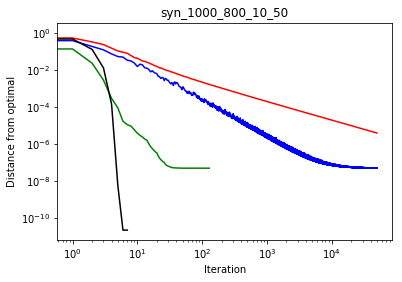

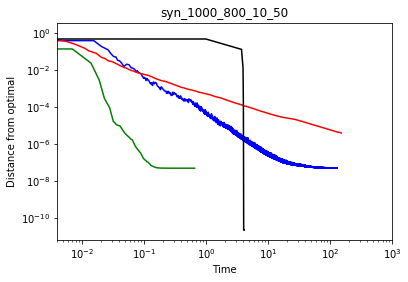

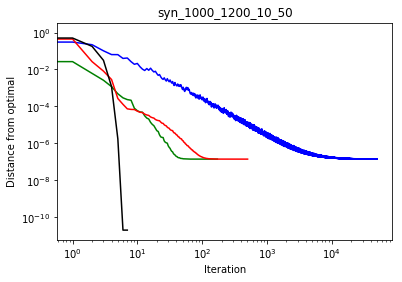

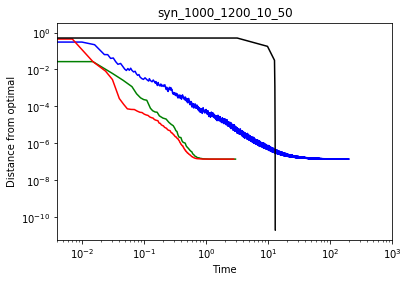

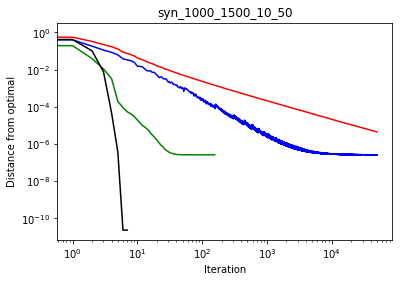

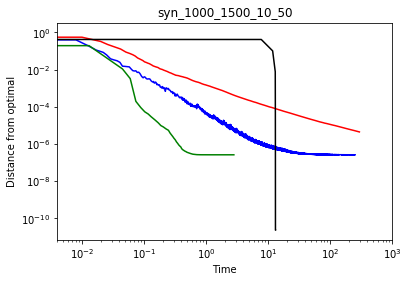

In [12]:
with open('./results/results_portfolio_dict.pckl', 'rb') as f:
        results=pickle.load(f)
k=0
colors={'icml':'r','standard':'b','line_search':'g','scopt':'k'}
for example in ['syn_1000_800_10_50','syn_1000_1200_10_50','syn_1000_1500_10_50']:
    min_Q=1e10
    for method in methods:
        min_Q=min(min(results[example][method]['Q_hist']),min_Q)
    min_Q=min_Q-1e-10
        
    plt.figure(k)
    for method in methods:
        plt.loglog((results[example][method]['Q_hist']-min_Q)/abs(min_Q),colors[method])
    plt.xlabel('Iteration')
    plt.ylabel('Distance from optimal')
    plt.title(example)
    
    k+=1
    plt.figure(k)
    for method in methods:
        plt.loglog(np.cumsum(results[example][method]['time_hist']),(results[example][method]['Q_hist']-min_Q)/abs(min_Q),colors[method])
    plt.xlim((0.4e-2,1e+3))
    plt.xlabel('Time')
    plt.ylabel('Distance from optimal')
    plt.title(example)
    k+=1